# Setup

In [63]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    read_data, read_model, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    percentile, clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient
)

In [64]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time
import catboost
from catboost import CatBoostRegressor, Pool

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [65]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
DATA_DIR = '../data/'

# Tree-Based Model Training

In [5]:
%%time
# Read the final dataframe from feature engineering notebook
train_path = f"{DATA_DIR}/optiver-train-data/train_by_batch_gen_v3.parquet"
train = read_data(train_path)
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 2.1 GB


0it [00:00, ?it/s]

After downcast: 	RAM used: 2.2 GB
CPU times: user 8.62 s, sys: 14.3 s, total: 22.9 s
Wall time: 10.8 s


In [6]:
# Set the target columns to avoid target leakage into X_train
target_column_list = get_cols(train, "target", excludes=["normalized", "daily", "grad"])
target_column_list

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [7]:
# # Get the list of features to avoid based on previous experiments / analysis
# corr_but_noob_features = joblib.load("../features_summary/corr_but_noob_features.pkl")
# print(corr_but_noob_features[:10])

In [8]:
# lgbm_model = read_model(f'{DATA_DIR}/optiver-lgbm-models/lgbm_model7.txt')
# imp_df = plot_feature_importance(lgbm_model.feature_name(), lgbm_model.feature_importance(), return_df=True)
# low_imp_features = imp_df.loc[imp_df["feature_importance"] < 140, "feature"].tolist()

In [9]:
def get_final_features(df, noob_features=[], target_columns=target_column_list, meta_columns=META_COLUMNS[:2]):
    return list_diff(df.columns, noob_features + target_columns + meta_columns)

In [10]:
train.shape

(5237760, 448)

## LGBM 

In [121]:
LGBM_MODEL_VERSION = 9
lgbm_val_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.txt'
lgbm_val_data_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.csv'
lgbm_final_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}.txt'

### Optuna Tuning (Ignore this first)

In [12]:
# def objective(trial):
#     va_score_list = []
#     # sampled_features = random.sample(feature_list, 350)
#     # track_features_list.append(sampled_features)
#     for i in range(2, 4):
#         cprint(f"{get_time_now()} Preparing Training Dataset...", color="green")
#         train_data = get_lgbm_dataset(train, start_date=0, end_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS, feature_list=feature_list)
#         # train_data = lgb.Dataset(
#         #     tr.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
#         #     tr["target"].values
#         # )
#         # del tr
#         gc.collect()
        
#         cprint(f"{get_time_now()} Preparing Validation Dataset...", color="green")
#         valid_data = get_lgbm_dataset(train, start_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, end_date=MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS, feature_list=feature_list)
        
#         # valid_data = lgb.Dataset(
#         #     va.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
#         #     va["target"].values,
#         #     reference=train_data
#         # )
        
#         cprint(f"{get_time_now()} Suggesting hyparameters for this trial...", color="green")
#         lgbm_trial_params = dict(
#             boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
#             learning_rate=trial.suggest_float("learning_rate", 0.02, 0.03), # 0.018052307589575444, 
#             max_depth=trial.suggest_categorical("max_depth", [10, 11, 12, -1]), 
#             n_estimators=trial.suggest_int("n_estimators", 400, 800, step=50),
#             num_leaves=trial.suggest_int("num_leaves", 350, 450, step=25), 
#             reg_alpha=trial.suggest_float("reg_alpha", 0.00001, 0.03, log=True), # 0.02216069565875271, 
#             reg_lambda=trial.suggest_float("reg_lambda", 0.00001, 0.03, log=True), # 0.01223572246957101,
#             colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 0.8),
#             subsample=trial.suggest_float("subsample", 0.5, 0.95),
#             min_child_samples=trial.suggest_int("min_child_samples", 32, 64, step=16),
#             verbose=-1
#         )
#         final_lgbm_params = default_settings | lgbm_trial_params
#         print(final_lgbm_params)
        
#         cprint(f"{get_time_now()} Model Training...", color="green")
#         model = lgb.train(
#             params=final_lgbm_params,
#             train_set=train_data, 
#             valid_sets=[valid_data, train_data], 
#             # feval=lgb_amex_metric, 
#             # early_stopping_rounds=200,
#             # categorical_feature=["stock_id"],
#             callbacks=[
#                 log_evaluation(100),
#             ]
#         )
#         del train_data, valid_data
#         gc.collect()
        
#         va = train.loc[train["date_id"].between(MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS)]
#         va_pred = lgbm_inference_by_batch(model, va, verbose=0)
#         va_score = (va_pred - va["target"]).abs().mean()
        
#         va_pred_zero_sum = zero_sum(va_pred, va['bid_size'] + va['ask_size'])
#         va_pred_zero_sum_score = (va_pred_zero_sum - va["target"]).abs().mean()
        
#         cprint(f"{get_time_now()} Ori score: {va_score:.5f}, Zero sum score: {va_pred_zero_sum_score:.5f}", color="blue")
#         va_score_list.append(va_pred_zero_sum_score)
        
#     return np.mean(va_score_list)

### First Training for Validation 

In [55]:
# We manually set here, but this can be str8 away came from optuna best hyper-params
lgbm_params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.016,
    # 'max_depth': 12,
    'n_estimators': 1200,
    'num_leaves': 350, 
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 0.62,
    'subsample': 0.65,
    'min_child_samples': 12,
    'min_split_gain': 0.2,  
    'min_child_weight': 0.001, 
    "device": "cpu"
}

In [56]:
# These are be the static hyperparams for our ML problem + your machine specifications
lgbm_general_settings = dict(
    objective='mae', 
    histogram_pool_size=256, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=512, 
    n_jobs=-1, 
    verbose=-1
)

In [57]:
# Final hyper-params set
full_lgbm_params = lgbm_general_settings | lgbm_params
print(full_lgbm_params)

{'objective': 'mae', 'histogram_pool_size': 256, 'force_col_wise': True, 'random_state': 1020, 'max_bin': 512, 'n_jobs': -1, 'verbose': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.016, 'n_estimators': 1200, 'num_leaves': 350, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.62, 'subsample': 0.65, 'min_child_samples': 12, 'min_split_gain': 0.2, 'min_child_weight': 0.001, 'device': 'cpu'}


In [58]:
feature_list = list_diff(train.columns.tolist(), META_COLUMNS[:2] + target_column_list)
# feature_list = imp_df.loc[:300, "feature"].tolist()
len(feature_list)

442

In [17]:
%%time
val_model, valid_pred, best_score = train_lgbm(
    data=train, train_start_date=1, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=feature_list, lgbm_params=full_lgbm_params
)

11:04:34 Preparing Dataset...
11:05:16 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.33172	training's mae: 6.33172	valid_0's l1: 5.71716	valid_0's mae: 5.71716
[200]	training's l1: 6.28259	training's mae: 6.28259	valid_0's l1: 5.69949	valid_0's mae: 5.69949
[300]	training's l1: 6.24065	training's mae: 6.24065	valid_0's l1: 5.69098	valid_0's mae: 5.69098
[400]	training's l1: 6.20246	training's mae: 6.20246	valid_0's l1: 5.68637	valid_0's mae: 5.68637
[500]	training's l1: 6.16642	training's mae: 6.16642	valid_0's l1: 5.68361	valid_0's mae: 5.68361
[600]	training's l1: 6.13356	training's mae: 6.13356	valid_0's l1: 5.68211	valid_0's mae: 5.68211
[700]	training's l1: 6.10274	training's mae: 6.10274	valid_0's l1: 5.68155	valid_0's mae: 5.68155
[800]	training's l1: 6.07431	training's mae: 6.07431	valid_0's l1: 5.6815	valid_0's mae: 5.6815
[900]	training's l1: 6.04828	training's mae: 6.04828	valid_0's l1: 5.68142	valid_0's mae: 5.68142
Early s

### Remove correlated features and retrain

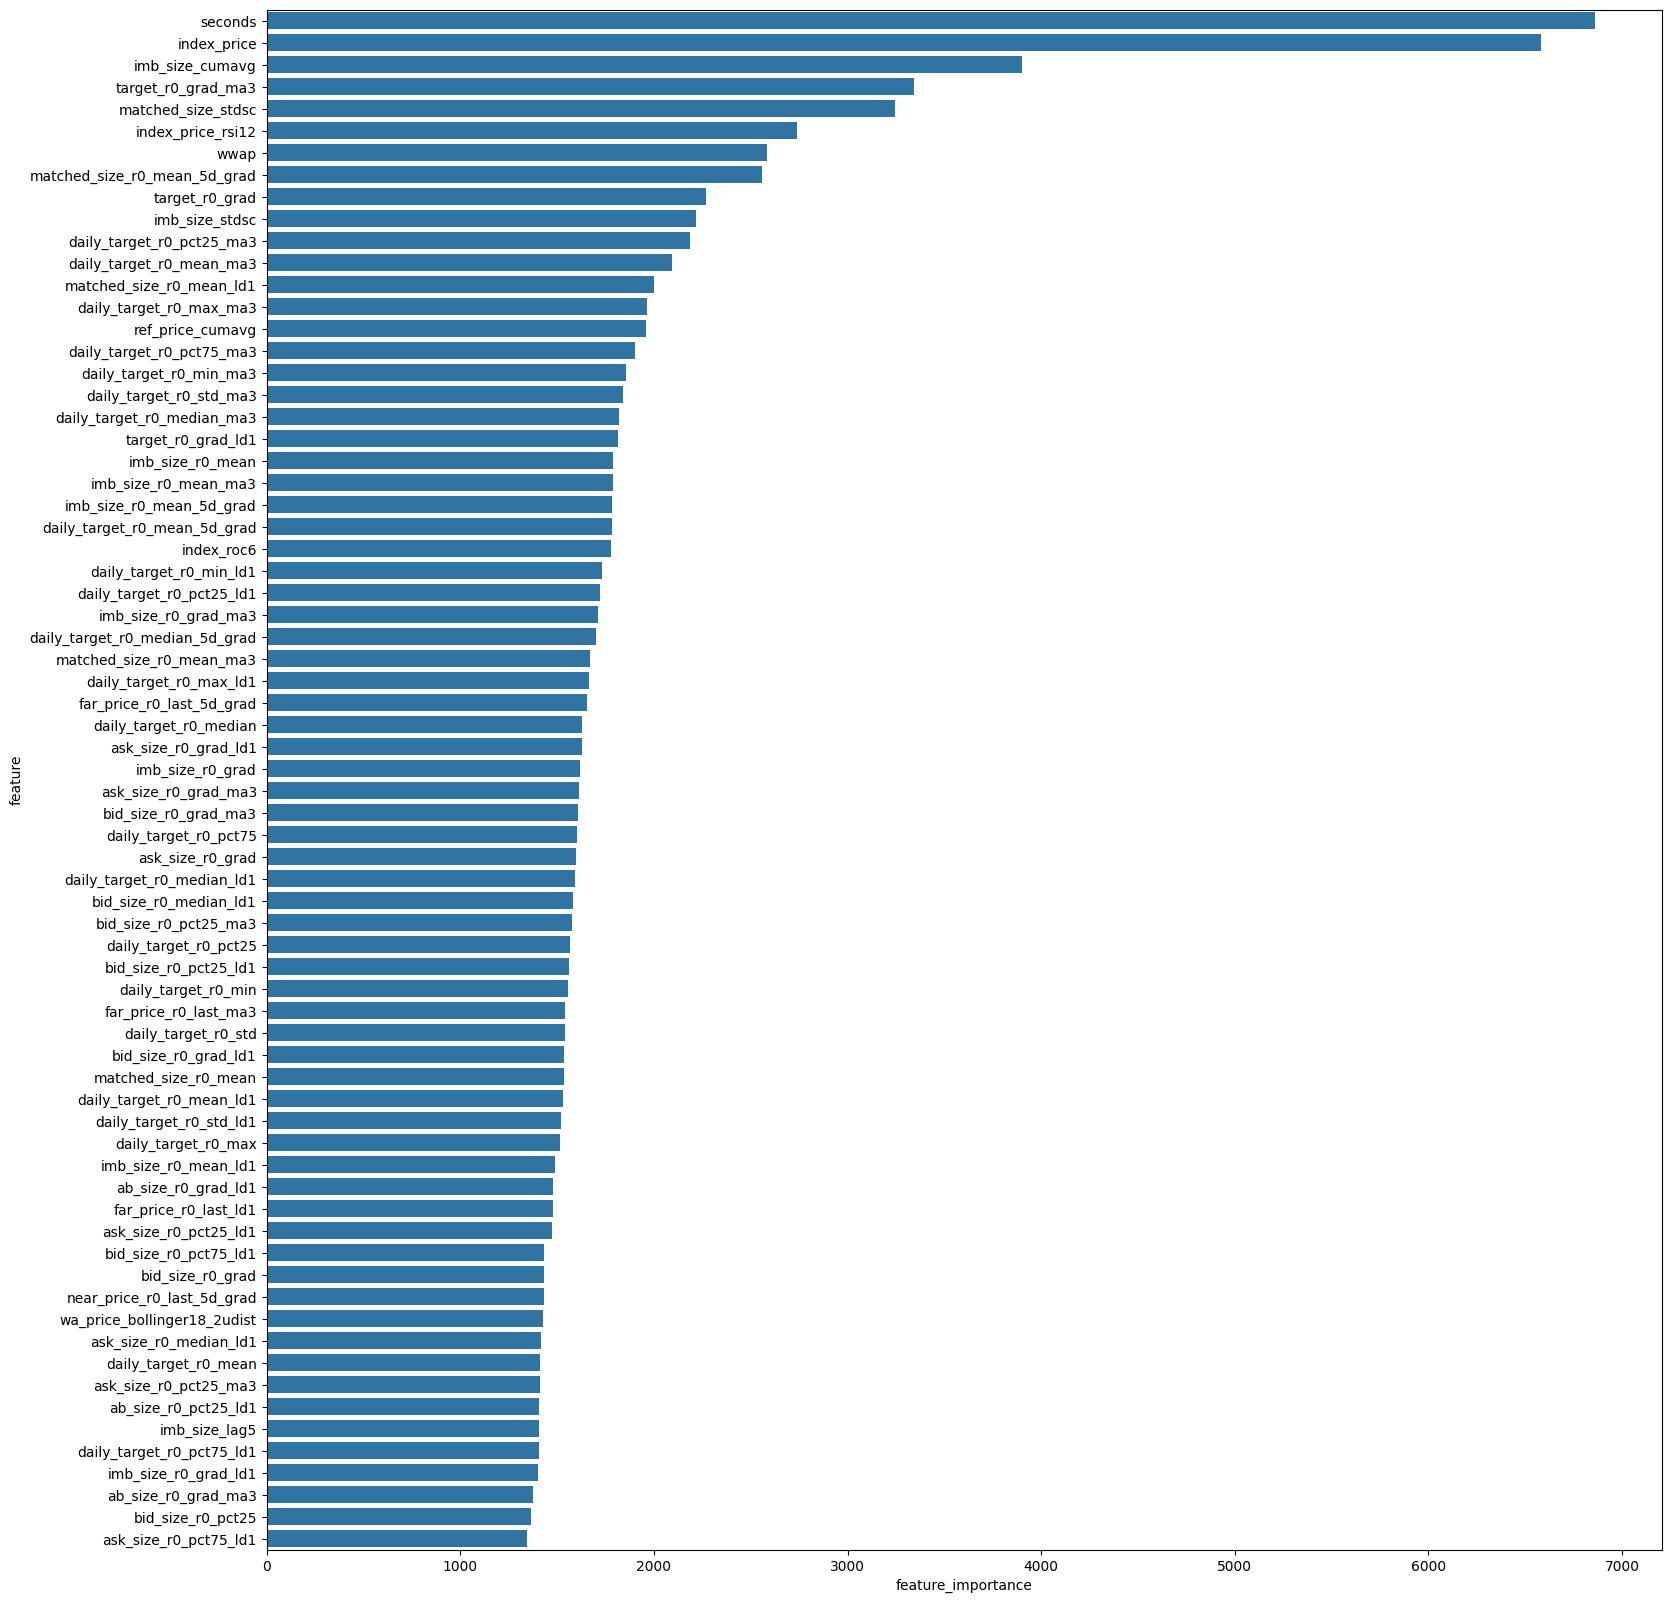

In [19]:
# val_model = read_model(f'{DATA_DIR}/lgbm_model{LGBM_MODEL_VERSION}_val.txt')
imp_df = plot_feature_importance(val_model.feature_name(), val_model.feature_importance(), return_df=True, limit=50, figsize=(18, 15))

In [27]:
low_imp_features = imp_df.loc[imp_df["feature_importance_rank"] >= 360, "feature"].tolist()

In [33]:
%%time
subset = filter_df(train, seconds=(200, 540), date_id=(391, 480), reset_index=True)
corr_df = subset.loc[:, imp_df["feature"].tolist()].corr()

CPU times: user 3min 13s, sys: 2.61 s, total: 3min 15s
Wall time: 3min 16s


In [40]:
imp_df.loc[imp_df["feature"].str.contains("s_ratio1")]

,feature,feature_importance,feature_importance_rank
224,index_price_s_ratio1,404,208
319,near_price_s_ratio1,193,290
369,imb_size_s_ratio1,97,327
376,far_price_s_ratio1,85,333
386,bid_size_s_ratio1,75,339
389,ref_price_s_ratio1,72,341
391,ask_size_s_ratio1,71,342
412,wa_price_s_ratio1,29,359
418,bid_price_s_ratio1,21,363
422,ask_price_s_ratio1,19,365


In [39]:
corr_df.loc[corr_df["seconds"].isnull()]

,seconds,index_price,imb_size_cumavg,target_r0_grad_ma3,matched_size_stdsc,index_price_rsi12,wwap,matched_size_r0_mean_5d_grad,target_r0_grad,imb_size_stdsc,...,bid_size_ab_size_fod_sum,index_price_rsi3_signal,matched_size_ab_size_fod_ratio,matched_size_bid_size_fod_ratio,imb_size_ab_size_fod_ratio,wa_price_rsi6_signal,ab_size_fod,imb_size_bid_size_fod_ratio,wa_price_rsi3_signal,imb_flag
index_price_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref_price_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wa_price_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bid_price_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ask_price_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wwap_s_ratio1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# corr_df = read_data("../corr_df.parquet")
linkage_matrix = sch.linkage(corr_df.fillna(0).values, method='ward', metric='euclidean')
clusters = fcluster(linkage_matrix, 0.015, criterion='distance')
feature_cluster_df = pd.DataFrame(dict(feature=corr_df.columns.tolist(), clusters=clusters))
best_features = feature_cluster_df.groupby("clusters")["feature"].apply(list).progress_apply(lambda x: imp_df.loc[imp_df["feature"].isin(x), "feature"].iloc[0]).tolist()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 8788.39it/s]


In [72]:
best_features = list_diff(best_features, low_imp_features)

In [73]:
len(best_features)

388

In [74]:
%%time
val_model2, valid_pred2, best_score2 = train_lgbm(
    data=train, train_start_date=1, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=best_features, lgbm_params=full_lgbm_params
)

13:30:14 Preparing Dataset...
13:30:48 Training...
Training until validation scores don't improve for 120 rounds
[50]	training's l1: 6.37165	training's mae: 6.37165	valid_0's l1: 5.7383	valid_0's mae: 5.7383
[100]	training's l1: 6.3273	training's mae: 6.3273	valid_0's l1: 5.71459	valid_0's mae: 5.71459
[150]	training's l1: 6.30043	training's mae: 6.30043	valid_0's l1: 5.70454	valid_0's mae: 5.70454
[200]	training's l1: 6.27606	training's mae: 6.27606	valid_0's l1: 5.69709	valid_0's mae: 5.69709
[250]	training's l1: 6.25414	training's mae: 6.25414	valid_0's l1: 5.69278	valid_0's mae: 5.69278
[300]	training's l1: 6.23261	training's mae: 6.23261	valid_0's l1: 5.68911	valid_0's mae: 5.68911
[350]	training's l1: 6.21212	training's mae: 6.21212	valid_0's l1: 5.68662	valid_0's mae: 5.68662
[400]	training's l1: 6.19269	training's mae: 6.19269	valid_0's l1: 5.68494	valid_0's mae: 5.68494
[450]	training's l1: 6.17373	training's mae: 6.17373	valid_0's l1: 5.68387	valid_0's mae: 5.68387
[500]	trai

In [75]:
valid_pred2["error"] = (valid_pred2["target"] - valid_pred2["val_pred"])
(valid_pred2["val_pred"] - valid_pred2["target"]).abs().mean()

5.681122044595316

In [77]:
if best_score2 < best_score:
    val_model2.save_model(val_model_path)
    valid_pred2.to_csv(val_data_path, index=False)

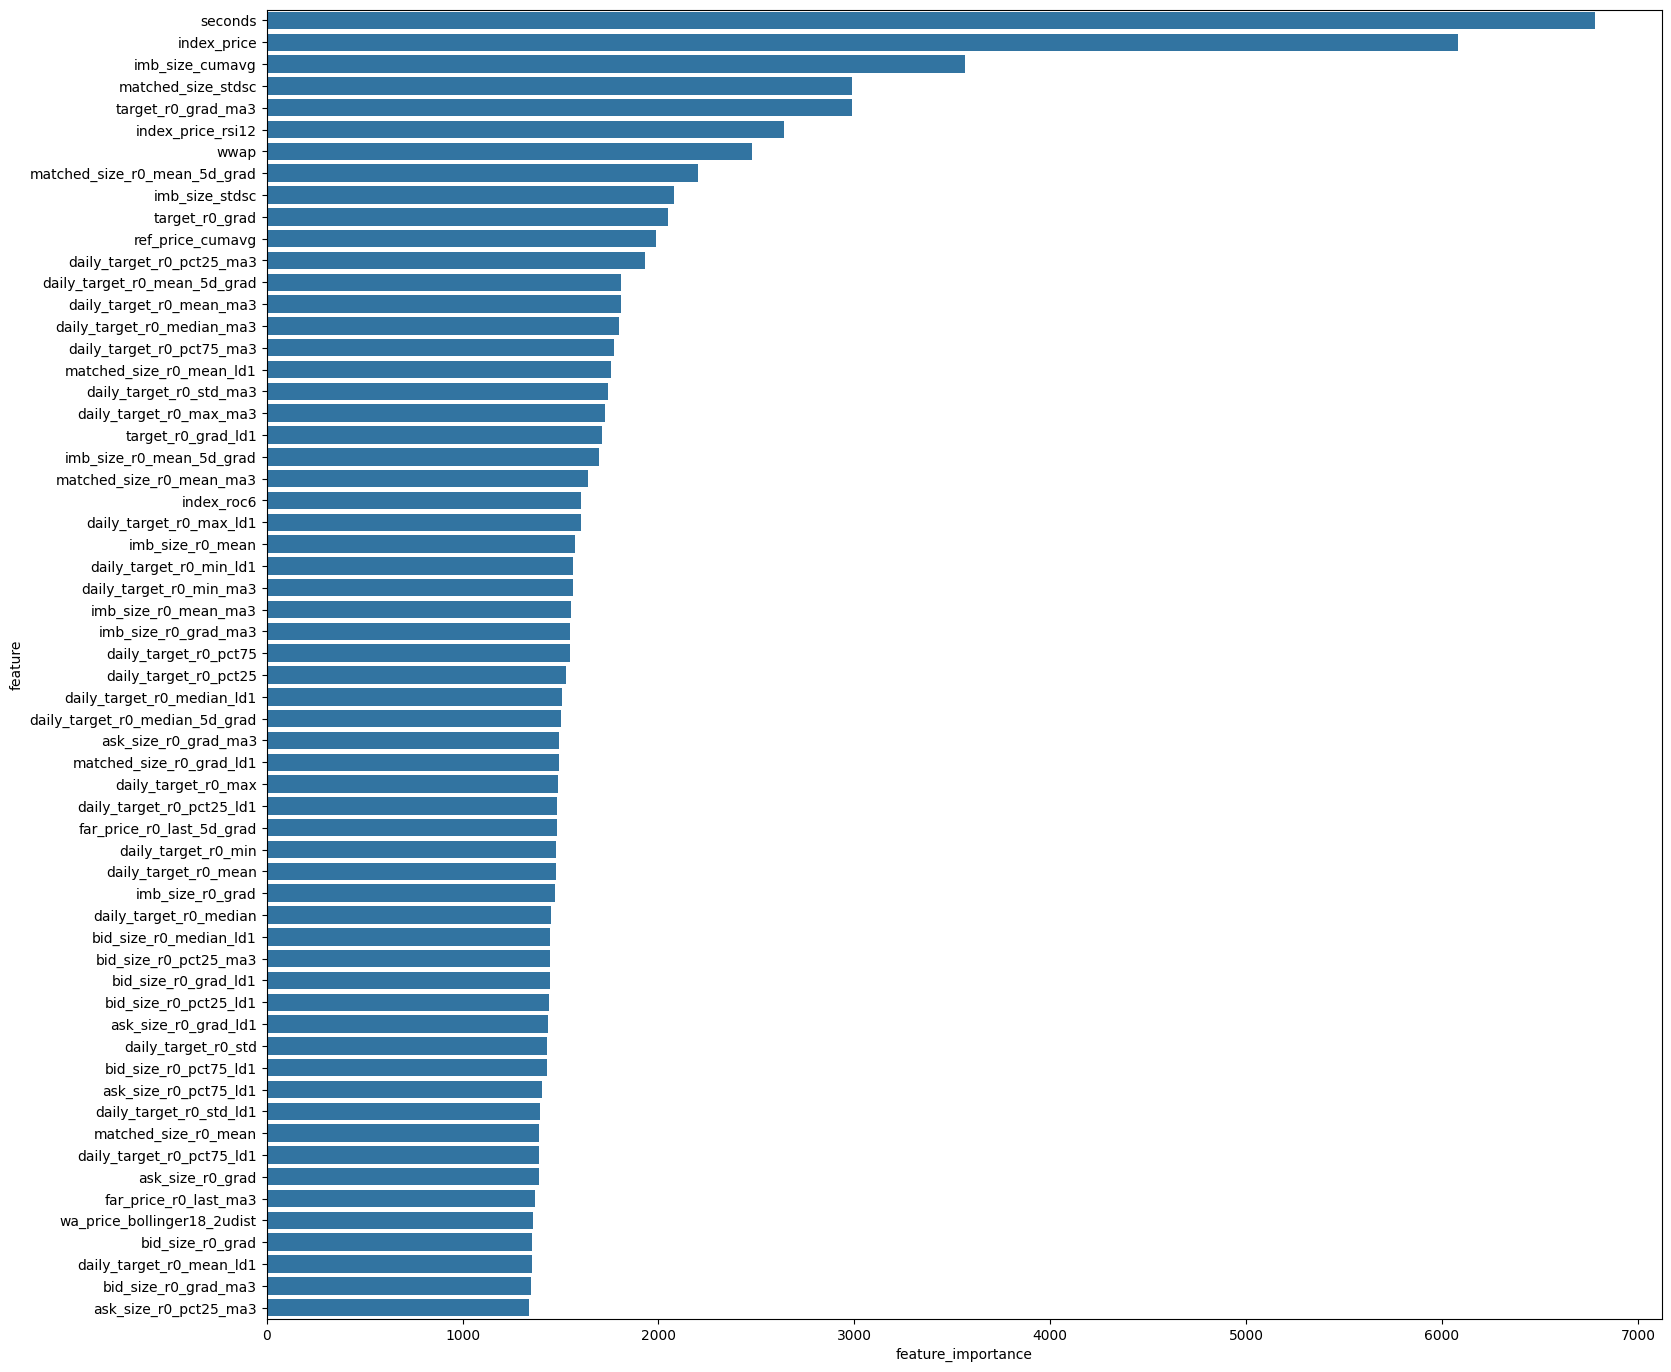

In [78]:
# val_model = read_model(f'{DATA_DIR}/lgbm_model{LGBM_MODEL_VERSION}_val.txt')
imp_df2 = plot_feature_importance(val_model2.feature_name(), val_model2.feature_importance(), return_df=True, limit=50, figsize=(18, 15))

In [79]:
# all_logp = read_data("../features_summary/features_logp_values.parquet")
# all_logp_metrics = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(.25)) + all_logp.apply(percentile(.75)))
# all_logp.head()
# plt.figure(figsize=(19, 15))
# all_logp_metrics = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(.25)) + all_logp.apply(percentile(.75)))
# all_logp_metrics.sort_values()[:30][::-1].plot.barh()
# plt.show()

### Train for Submission (Final Model) 

In [80]:
# Use back the same features, so that the validation score holds
best_new_features = best_features

In [81]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_lgbm_params = full_lgbm_params
best_lgbm_params["n_estimators"] = int(val_model2.best_iteration * 1.1)
best_lgbm_params

{'objective': 'mae',
 'histogram_pool_size': 256,
 'force_col_wise': True,
 'random_state': 1020,
 'max_bin': 512,
 'n_jobs': -1,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'learning_rate': 0.016,
 'n_estimators': 855,
 'num_leaves': 350,
 'reg_alpha': 0.1,
 'reg_lambda': 0.3,
 'colsample_bytree': 0.62,
 'subsample': 0.65,
 'min_child_samples': 12,
 'min_split_gain': 0.2,
 'min_child_weight': 0.001,
 'device': 'cpu'}

In [82]:
%%time
lgbm_model, _, _ = train_lgbm(
    data=train, train_start_date=1, train_end_date=480, val_start_date=478, 
    es=False, get_val_pred=False, feature_list=best_new_features, lgbm_params=best_lgbm_params
)

14:28:18 Preparing Dataset...
14:28:51 Training...
[50]	training's l1: 6.29121	training's mae: 6.29121	valid_0's l1: 5.201	valid_0's mae: 5.201
[100]	training's l1: 6.24956	training's mae: 6.24956	valid_0's l1: 5.17548	valid_0's mae: 5.17548
[150]	training's l1: 6.22503	training's mae: 6.22503	valid_0's l1: 5.1579	valid_0's mae: 5.1579
[200]	training's l1: 6.20258	training's mae: 6.20258	valid_0's l1: 5.14148	valid_0's mae: 5.14148
[250]	training's l1: 6.18267	training's mae: 6.18267	valid_0's l1: 5.12629	valid_0's mae: 5.12629
[300]	training's l1: 6.16357	training's mae: 6.16357	valid_0's l1: 5.11252	valid_0's mae: 5.11252
[350]	training's l1: 6.14563	training's mae: 6.14563	valid_0's l1: 5.09901	valid_0's mae: 5.09901
[400]	training's l1: 6.12799	training's mae: 6.12799	valid_0's l1: 5.08533	valid_0's mae: 5.08533
[450]	training's l1: 6.11133	training's mae: 6.11133	valid_0's l1: 5.07238	valid_0's mae: 5.07238
[500]	training's l1: 6.09534	training's mae: 6.09534	valid_0's l1: 5.06028

In [52]:
%%time
lgbm_model.save_model(final_model_path)

CPU times: user 623 ms, sys: 260 ms, total: 883 ms
Wall time: 122 ms


In [83]:
gc.collect()

16314

## CatBoost

In [120]:
CAT_MODEL_VERSION = "3"
cat_val_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.cbm"
cat_val_data_path = f'{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.csv'
cat_final_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}.cbm"

### Optuna Tuning

In [85]:
def objective(trial):
    # Set the hyperparameter range to tune
    params = dict(
        iterations=trial.suggest_int("iterations", 1700, 2500),
        learning_rate=trial.suggest_float("learning_rate", 0.015, 0.02, log=True),
        depth=trial.suggest_int("depth", 10, 12),
        subsample=trial.suggest_float("subsample", 0.88, 0.95),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.85, 0.93),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 10, 18, step=4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 3, 5),
        border_count=trial.suggest_int("border_count", 64, 256, step=32),
        nan_mode="Max", # trial.suggest_categorical("nan_mode", ["Min", "Max"]),
        sampling_frequency="PerTreeLevel", # trial.suggest_categorical("sampling_frequency", ["PerTree", "PerTreeLevel"]),
        langevin=True, # trial.suggest_categorical("langevin", [True, False]),
        mvs_reg=trial.suggest_float("mvs_reg", 1.5, 3),
        loss_function="MAE", 
        grow_policy="SymmetricTree",
        bootstrap_type="MVS", 
        random_state=999, 
        verbose=0,
    )
    cprint(f"{get_time_now()}, Hyperparams: {params}", color="green")
    model = CatBoostRegressor(**params)
    model.fit(X_tr, y_tr)
    cprint(f"{get_time_now()}, Done Training, Predicting Now...", color="green")
    y_va_pred = model.predict(X_va)
    mae = (y_va_pred - y_va).abs().mean()
    return mae

In [86]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

### Train for Validation

In [87]:
# prev_catboost_val_model = read_model(f"{DATA_DIR}/optiver-catboost-models/cat_model1_val.cbm")
# prev_catboost_val_model

In [88]:
# These are be the static hyperparams for our ML problem + your machine specifications
cat_general_settings = dict(
    loss_function='MAE', 
    random_state=923,
    task_type="CPU", 
    verbose=1
)

In [89]:
# We manually set here, but this can be str8 away came from optuna best hyper-params
cat_params = {
    'iterations': 1200,
    'learning_rate': 0.05,
    'depth': 11,
    'subsample': 0.88,
    'colsample_bylevel': 0.85,
    'min_data_in_leaf': 12,
    'l2_leaf_reg': 3.98,
    'border_count': 150,
    'mvs_reg': 2.645,
    'sampling_frequency': 'PerTreeLevel',
    'langevin': True,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
    'use_best_model': True, 
    'od_type': "Iter",
    'od_wait': 100,
    'metric_period': 25,
}

In [90]:
# Final hyper-params set
full_cat_params = cat_general_settings | cat_params
print(full_cat_params)

{'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


In [91]:
len(feature_list)

442

In [92]:
%%time
tr = filter_df(train, date_id=(0, 420), seconds=(0, 540)).reset_index(drop=True)
va = filter_df(train, date_id=(421, 480), seconds=(0, 540)).reset_index(drop=True)

X_tr = tr.loc[:, feature_list]
y_tr = tr["clipped_target"]
X_va = va.loc[:, feature_list]
y_va = va["target"]

CPU times: user 2.4 s, sys: 14.8 s, total: 17.2 s
Wall time: 53.4 s


In [93]:
del tr, va
gc.collect()

144

In [94]:
# X_tr = X_tr.dropna(how="all", axis=1)
# X_va = X_va.dropna(how="all", axis=1)

In [95]:
%%time
cprint(f"{get_time_now()}, Hyperparams: {full_cat_params}", color="green")
val_model = CatBoostRegressor(**full_cat_params)
val_model.fit(
    X_tr, 
    y_tr,
    eval_set=Pool(X_va, y_va)
)

15:14:23, Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


0:	learn: 6.4765807	test: 5.8079807	best: 5.8079807 (0)	total: 4.25s	remaining: 1h 25m 2s
25:	learn: 6.3627594	test: 5.7306554	best: 5.7306554 (25)	total: 1m 46s	remaining: 1h 20m 4s
50:	learn: 6.3322990	test: 5.7141279	best: 5.7141279 (50)	total: 3m 32s	remaining: 1h 19m 41s
75:	learn: 6.3134216	test: 5.7056219	best: 5.7056219 (75)	total: 5m 25s	remaining: 1h 20m 11s
100:	learn: 6.2988291	test: 5.6995209	best: 5.6995209 (100)	total: 7m 25s	remaining: 1h 20m 50s
125:	learn: 6.2858233	test: 5.6965501	best: 5.6965501 (125)	total: 9m 38s	remaining: 1h 22m 13s
150:	learn: 6.2737545	test: 5.6937213	best: 5.6937213 (150)	total: 11m 47s	remaining: 1h 21m 53s
175:	learn: 6.2629294	test: 5.6915993	best: 5.6915946 (174)	total: 13m 49s	remaining: 1h 20m 26s
200:	learn: 6.2525175	test: 5.6905062	best: 5.6905062 (200)	total: 15m 50s	remaining: 1h 18m 42s
225:	learn: 6.2418771	test: 5.6890564	best: 5.6890564 (225)	total: 17m 54s	remaining: 1h 17m 12s
250:	learn: 6.2320629	test: 5.6885416	best: 5.688

In [113]:
model.save_model(cat_val_model_path)

### Remove correlated features and retrain

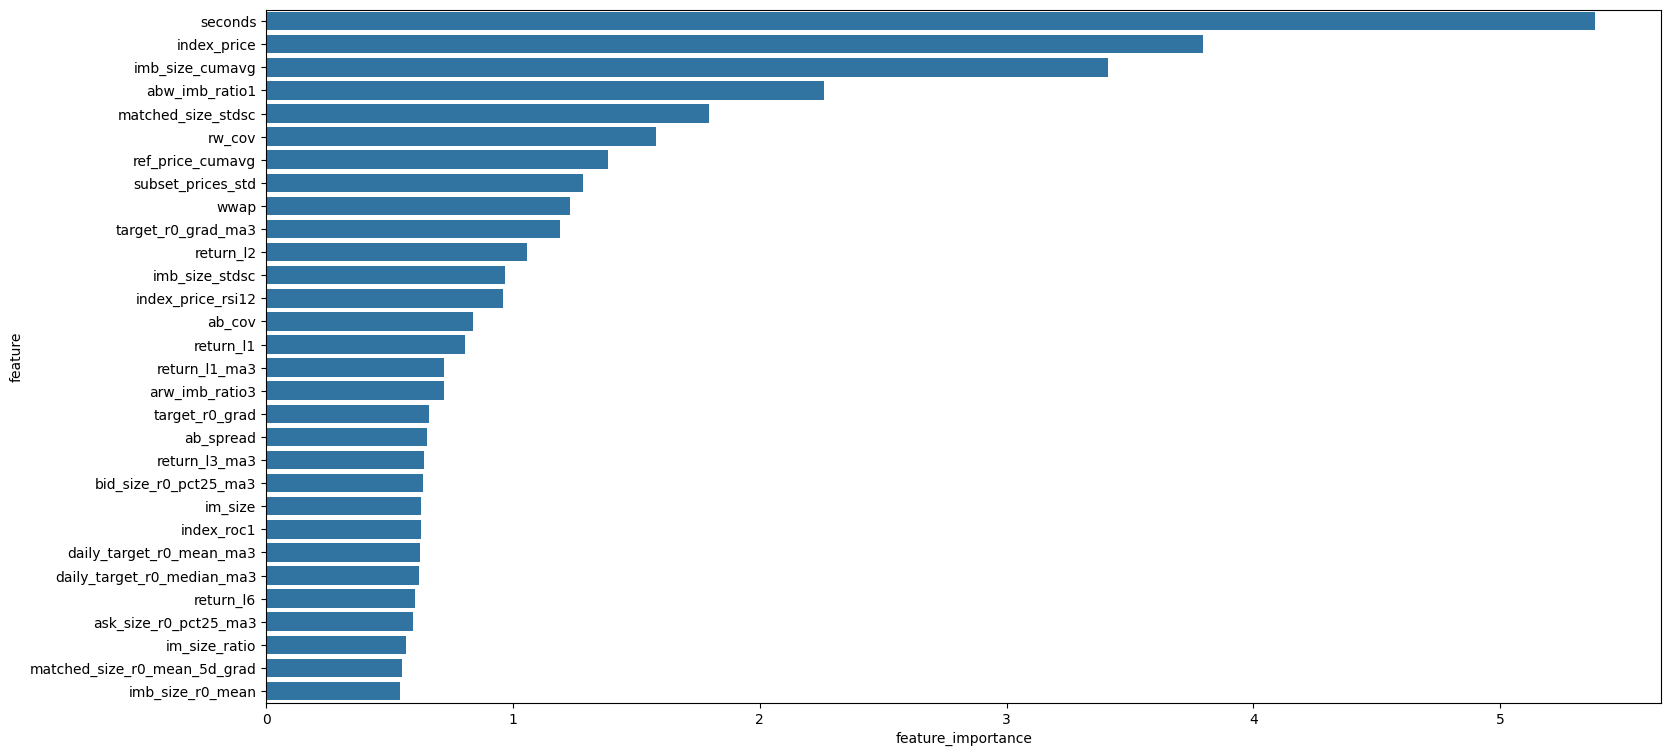

In [114]:
cat_imp_df = plot_feature_importance(model.feature_names_, model.get_feature_importance(), return_df=True, limit=30, figsize=(18, 9))

In [100]:
low_imp_features = cat_imp_df.loc[cat_imp_df["feature_importance_rank"] >= 380, "feature"].tolist()
len(low_imp_features)

63

In [108]:
# corr_df = read_data("../corr_df.parquet")

In [101]:
corr_df = corr_df.loc[cat_imp_df.feature.tolist(), cat_imp_df.feature.tolist()]

In [106]:
linkage_matrix = sch.linkage(corr_df.fillna(0).values, method='ward', metric='euclidean')
clusters = fcluster(linkage_matrix, 0.01, criterion='distance')
feature_cluster_df = pd.DataFrame(dict(feature=corr_df.columns.tolist(), clusters=clusters))
best_features = feature_cluster_df.groupby("clusters")["feature"].apply(list).progress_apply(lambda x: cat_imp_df.loc[cat_imp_df["feature"].isin(x), "feature"].iloc[0]).tolist()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:00<00:00, 8561.23it/s]


In [107]:
best_features = list_diff(best_features, low_imp_features)
len(best_features)

362

In [109]:
%%time
tr = filter_df(train, date_id=(0, 420), seconds=(0, 540)).reset_index(drop=True)
va = filter_df(train, date_id=(421, 480), seconds=(0, 540)).reset_index(drop=True)

X_tr = tr.loc[:, best_features]
y_tr = tr["clipped_target"]
X_va = va.loc[:, best_features]
y_va = va["target"]

CPU times: user 2.33 s, sys: 14.7 s, total: 17.1 s
Wall time: 1min 4s


In [110]:
del tr
gc.collect()

736

In [111]:
%%time
cprint(f"{get_time_now()}, Hyperparams: {full_cat_params}", color="green")
model = CatBoostRegressor(**full_cat_params)
model.fit(
    X_tr, 
    y_tr,
    eval_set=Pool(X_va, y_va)
)

16:22:34, Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


0:	learn: 6.4754545	test: 5.8075804	best: 5.8075804 (0)	total: 4.07s	remaining: 1h 21m 21s
25:	learn: 6.3626365	test: 5.7302467	best: 5.7302467 (25)	total: 1m 31s	remaining: 1h 9m 13s
50:	learn: 6.3327436	test: 5.7130333	best: 5.7130333 (50)	total: 3m 1s	remaining: 1h 8m 17s
75:	learn: 6.3145949	test: 5.7055247	best: 5.7055247 (75)	total: 4m 35s	remaining: 1h 7m 55s
100:	learn: 6.3000416	test: 5.6999967	best: 5.6999967 (100)	total: 6m 12s	remaining: 1h 7m 34s
125:	learn: 6.2866400	test: 5.6959356	best: 5.6959356 (125)	total: 7m 52s	remaining: 1h 7m 6s
150:	learn: 6.2740121	test: 5.6934035	best: 5.6934035 (150)	total: 9m 36s	remaining: 1h 6m 41s
175:	learn: 6.2619408	test: 5.6914929	best: 5.6914929 (175)	total: 11m 18s	remaining: 1h 5m 49s
200:	learn: 6.2499609	test: 5.6895784	best: 5.6895784 (200)	total: 13m 25s	remaining: 1h 6m 42s
225:	learn: 6.2400244	test: 5.6888472	best: 5.6888472 (225)	total: 15m 33s	remaining: 1h 7m 1s
250:	learn: 6.2294973	test: 5.6879872	best: 5.6879872 (250)	

In [115]:
cprint(f"{get_time_now()}, Done Training, Predicting Now...", color="green")
va["cat_pred"] = model.predict(X_va)
mae = (va["cat_pred"] - y_va).abs().mean()
print(mae)

17:11:13, Done Training, Predicting Now...
5.683970710490443


In [116]:
model.save_model(val_model_path)

In [117]:
va = va[META_COLUMNS + ["target", "cat_pred"]]
va.to_csv(val_data_path, index=False)

### Train for Submission (Final Model)

In [118]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_cat_params = full_cat_params
best_cat_params["iterations"] = int(model.best_iteration_ * 1.1)
best_cat_params["use_best_model"] = False
best_cat_params

{'loss_function': 'MAE',
 'random_state': 923,
 'task_type': 'CPU',
 'verbose': 1,
 'iterations': 603,
 'learning_rate': 0.05,
 'depth': 11,
 'subsample': 0.88,
 'colsample_bylevel': 0.85,
 'min_data_in_leaf': 12,
 'l2_leaf_reg': 3.98,
 'border_count': 150,
 'mvs_reg': 2.645,
 'sampling_frequency': 'PerTreeLevel',
 'langevin': True,
 'grow_policy': 'SymmetricTree',
 'bootstrap_type': 'MVS',
 'use_best_model': False,
 'od_type': 'Iter',
 'od_wait': 100,
 'metric_period': 25}

In [122]:
%%time
tr = filter_df(train, date_id=(1, 480)).reset_index(drop=True)
va = filter_df(train, date_id=(478, 480)).reset_index(drop=True)

CPU times: user 1.83 s, sys: 10.5 s, total: 12.3 s
Wall time: 48.5 s


In [123]:
%%time
X_tr = tr.loc[:, best_features]
y_tr = tr["clipped_target"]
X_va = va.loc[:, best_features]
y_va = va["target"]

CPU times: user 342 ms, sys: 2.85 s, total: 3.19 s
Wall time: 10.1 s


In [130]:
check_memory_usage()

RAM used: 2.2 GB


2.1542510986328125

In [131]:
%%time
cprint(f"{get_time_now()}, Best Hyperparams: {best_cat_params}", color="green")
final_model = CatBoostRegressor(**best_cat_params)
final_model.fit(
    X_tr, 
    y_tr
)

02:37:02, Best Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 865, 'learning_rate': 0.04, 'depth': 10, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 18, 'l2_leaf_reg': 4.045, 'border_count': 128, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': False, 'od_type': 'Iter', 'od_wait': 90, 'metric_period': 25}
0:	learn: 6.3945289	total: 3.59s	remaining: 51m 41s
25:	learn: 6.2988232	total: 1m 32s	remaining: 49m 58s
50:	learn: 6.2727067	total: 3m	remaining: 48m
75:	learn: 6.2584969	total: 4m 34s	remaining: 47m 29s
100:	learn: 6.2477157	total: 6m 12s	remaining: 46m 57s
125:	learn: 6.2392394	total: 7m 58s	remaining: 46m 43s
150:	learn: 6.2316978	total: 9m 45s	remaining: 46m 7s
175:	learn: 6.2243617	total: 11m 35s	remaining: 45m 21s
200:	learn: 6.2180567	total: 13m 22s	remaining: 44m 11s
225:	learn: 6.2121231	total: 15

In [132]:
final_model.save_model(final_model_path)

## Try R1 R2 Models

In [35]:
train_r1 = filter_df(train, seconds=(0, 290), reset_index=True)
train_r2 = filter_df(train, seconds=(300, 540), reset_index=True)
train_r1 = train_r1.dropna(how="all", axis=1)
assert (train_r1.shape[0] + train_r2.shape[0]) == train.shape[0], "Not Tally"

r1_features = get_final_features(train_r1, corr_but_noob_features, target_columns=target_column_list)
r2_features = get_final_features(train_r2, corr_but_noob_features, target_columns=target_column_list)
len(r1_features), len(r2_features)

(271, 320)

In [38]:
%%time
val_model_r2, valid_pred_r2, best_score = train_lgbm(
    data=train_r2, train_start_date=0, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=r2_features, lgbm_params=final_lgbm_params
)

11:26:37 Preparing Dataset...
11:26:44 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 5.65184	training's mae: 5.65184	valid_0's l1: 4.9485	valid_0's mae: 4.9485
[200]	training's l1: 5.54782	training's mae: 5.54782	valid_0's l1: 4.93295	valid_0's mae: 4.93295
[300]	training's l1: 5.46663	training's mae: 5.46663	valid_0's l1: 4.92811	valid_0's mae: 4.92811
[400]	training's l1: 5.39743	training's mae: 5.39743	valid_0's l1: 4.92629	valid_0's mae: 4.92629
[500]	training's l1: 5.33653	training's mae: 5.33653	valid_0's l1: 4.92631	valid_0's mae: 4.92631
Early stopping, best iteration is:
[448]	training's l1: 5.36747	training's mae: 5.36747	valid_0's l1: 4.92575	valid_0's mae: 4.92575
Evaluated only: l1
11:35:00 Getting Validation Prediction...
CPU times: user 52min 45s, sys: 10min 45s, total: 1h 3min 31s
Wall time: 8min 26s


In [ ]:
final_val = pd.concat([valid_pred_r1, valid_pred_r2], ignore_index=True)
final_val = final_val.merge(train[META_COLUMNS + ["target"]], on=META_COLUMNS, how="left")
final_val = final_val.merge(va[META_COLUMNS + ["lgbm_v7_pred"]], on=META_COLUMNS, how="left")
final_val["avg"] = (final_val["lgbm_v7_pred"] + final_val["val_pred"]) / 2

# Feature Analysis

In [13]:
all_logp = pd.read_csv("../features_summary/features_logp_values.csv")
all_logp.head()

,stock_id,date_id,seconds,ab_gap,ab_gap_ar_gap_fod_ratio,ab_gap_ar_gap_fod_spread,ab_gap_ar_gap_fod_sum,ab_gap_aw_gap_fod_ratio,ab_gap_aw_gap_fod_spread,ab_gap_aw_gap_fod_sum,...,abm_imb_ratio3,price_pressure,market_urgency,wwap,abm_imb_ratio1,bim_imb_ratio3,bw_depth_pressure,am_st_ratio,weight,ab_st_ratio
0,0,-461.57883,-389.206270,-187.82472,-25.712883,-70.565020,-71.720665,-7.982771,-31.442432,-39.312466,...,-15.109345,-199.10718,-105.01898,-41.105220,-15.693370,-69.164055,-9.284789,-38.769245,0.0,-8.999992
1,1,-255.99847,-50.908030,-95.85843,-1.970455,-31.303220,-18.432371,-7.302582,-58.321200,-107.524920,...,-2.285080,-34.22804,-745.00000,-56.152970,-2.340367,-55.779106,-373.447080,-140.826050,0.0,-483.384340
2,2,-285.27423,-60.181583,-226.42468,-1.753751,-57.731570,-32.764600,-15.509977,-67.374170,-194.751070,...,-5.372412,-132.27824,-745.00000,-69.289580,-5.385533,-54.519524,-422.289370,-184.418170,0.0,-438.427280
3,3,-476.75760,-417.776340,-167.16582,-8.670104,-68.847800,-52.333294,-3.675680,-40.057570,-42.837223,...,-7.751771,-196.29108,-151.11436,-26.448440,-7.775989,-69.673400,-27.209745,-26.891043,0.0,-30.637623
4,4,-296.97943,-285.855220,-128.71718,-23.655752,-33.396355,-18.730232,-4.442601,-29.449490,-52.478240,...,-5.359083,-91.10555,-223.43639,-33.808147,-5.362135,-45.823254,-83.076580,-33.435528,0.0,-95.377370


In [16]:
all_logp = all_logp.set_index("stock_id")

In [28]:
all_logp_agg = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(0.75)) + all_logp.apply(percentile(0.25)))

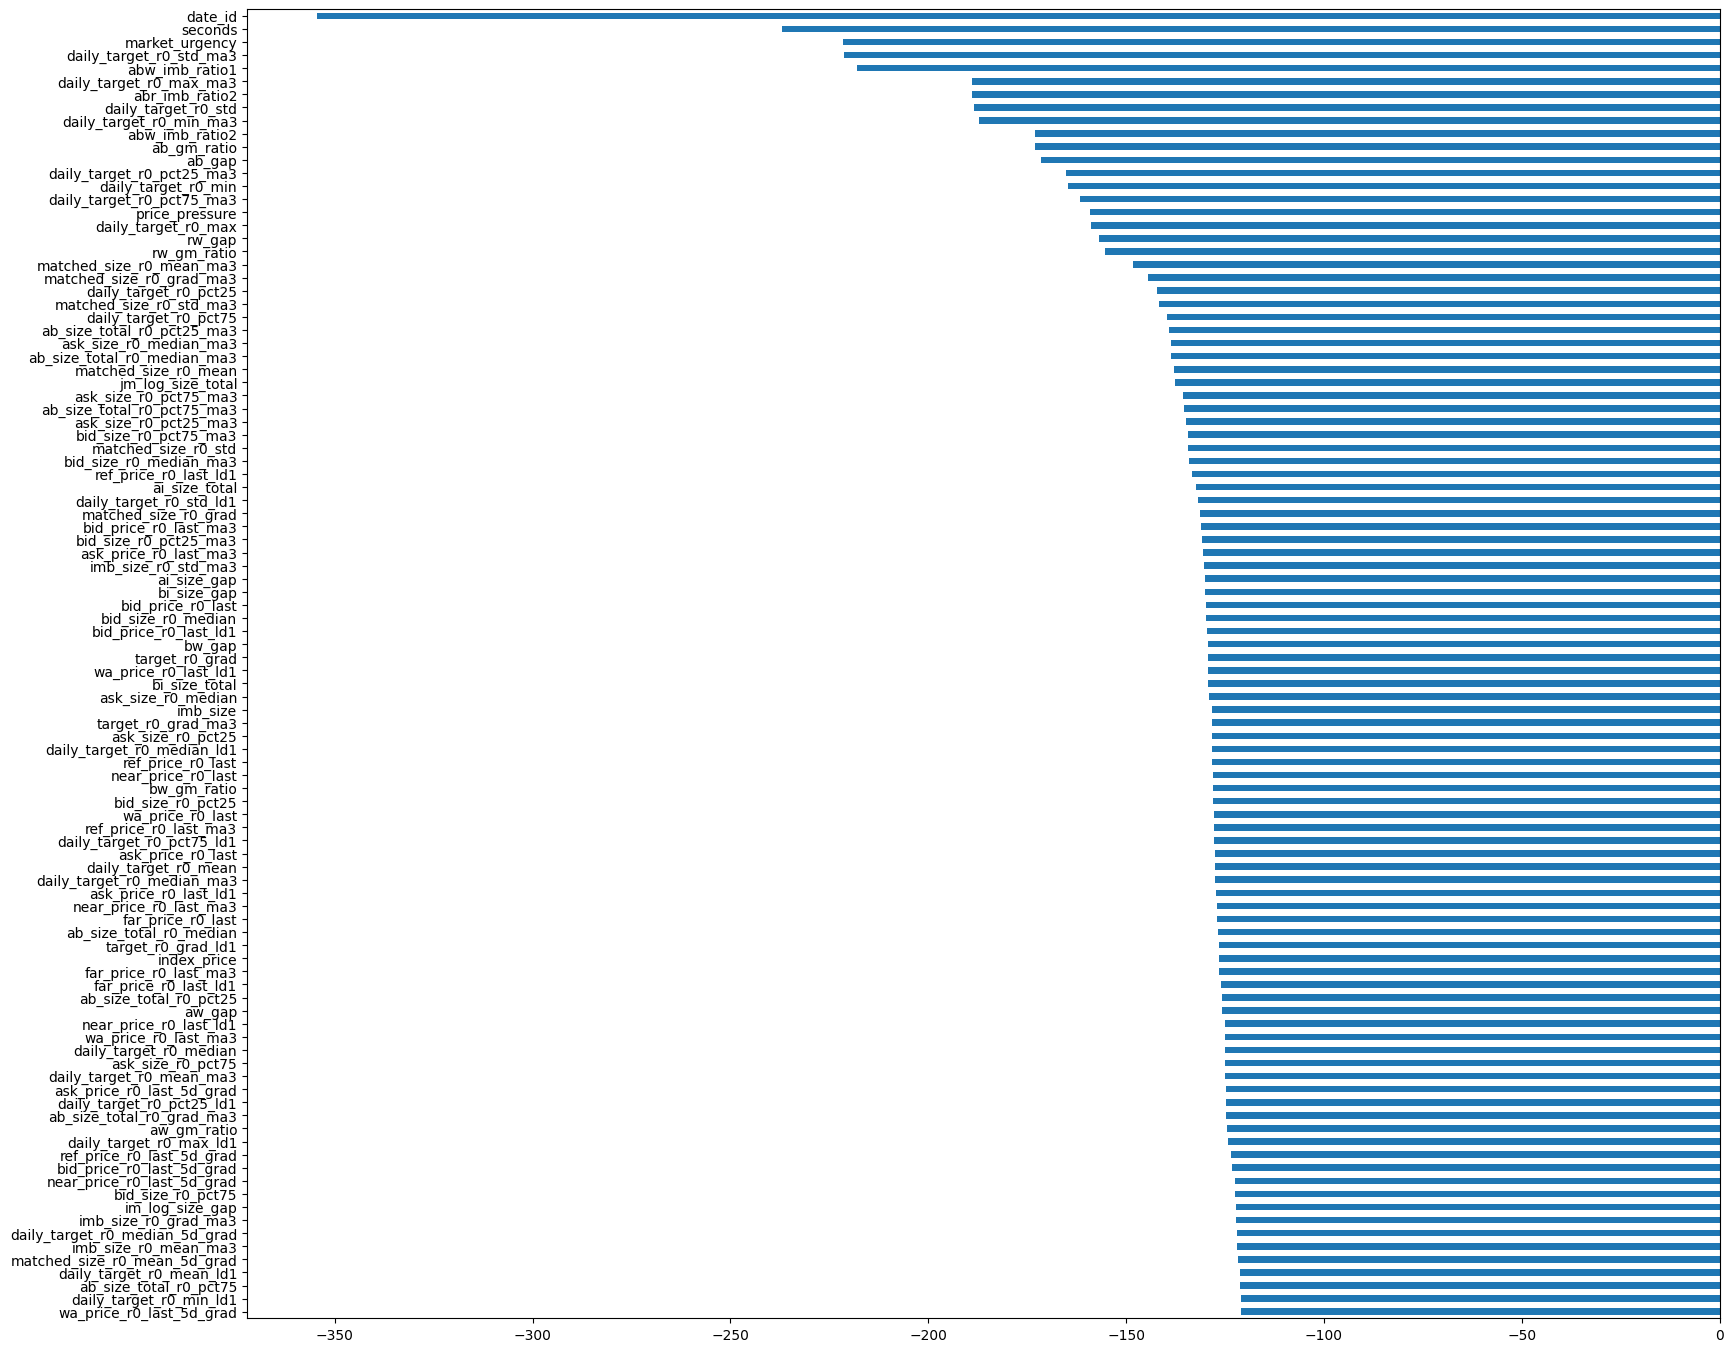

In [38]:
plt.figure(figsize=(19, 17))
all_logp_agg.sort_values()[:100][::-1].plot.barh()
plt.show()

# Error Analysis

# Test Simple Averaging Ensemble

In [127]:
cat_val_data_path

'../data//optiver-catboost-models/cat_model3_val.csv'

In [128]:
lgbm_val_data_path

'../data//optiver-lgbm-models/lgbm_model9_val.csv'

In [178]:
get_cols(train, "rbtsc")

['bid_size_rbtsc', 'ask_size_rbtsc']

In [179]:
cat = read_data(cat_val_data_path)
lgbm = read_data(lgbm_val_data_path)
lgbm["cat_pred"] = cat["cat_pred"]
lgbm["final_pred"] = (.5 * lgbm["cat_pred"] + .5 * lgbm["val_pred"])
lgbm = lgbm.merge(train[META_COLUMNS + ["bid_size", "ask_size", "matched_size", "ab_size_gap", "ask_size_rbtsc", "bid_size_rbtsc"]], on=META_COLUMNS, how="left")
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm['bid_size'] + lgbm['ask_size']
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.678987665792115

In [180]:
c1 = read_data("../data/optiver-catboost-models/cat_model2_val.csv")
l1 = read_data("../data/optiver-lgbm-models/lgbm_model8_val.csv")

In [181]:
lgbm["cat_pred1"] = c1["cat_pred"]
lgbm["val_pred1"] = l1["val_pred"]

In [182]:
lgbm["final_pred"] = 0.25 * (lgbm["cat_pred1"] + lgbm["cat_pred"] + lgbm["val_pred"] + lgbm["val_pred1"])
(lgbm["final_pred"] - lgbm["target"]).abs().mean()

5.677299856265766

In [192]:
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm["ask_size"] * np.abs(my_log(lgbm["ask_size_rbtsc"])) + lgbm["bid_size"] * np.abs(my_log(lgbm["bid_size_rbtsc"]))
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.677356032170784

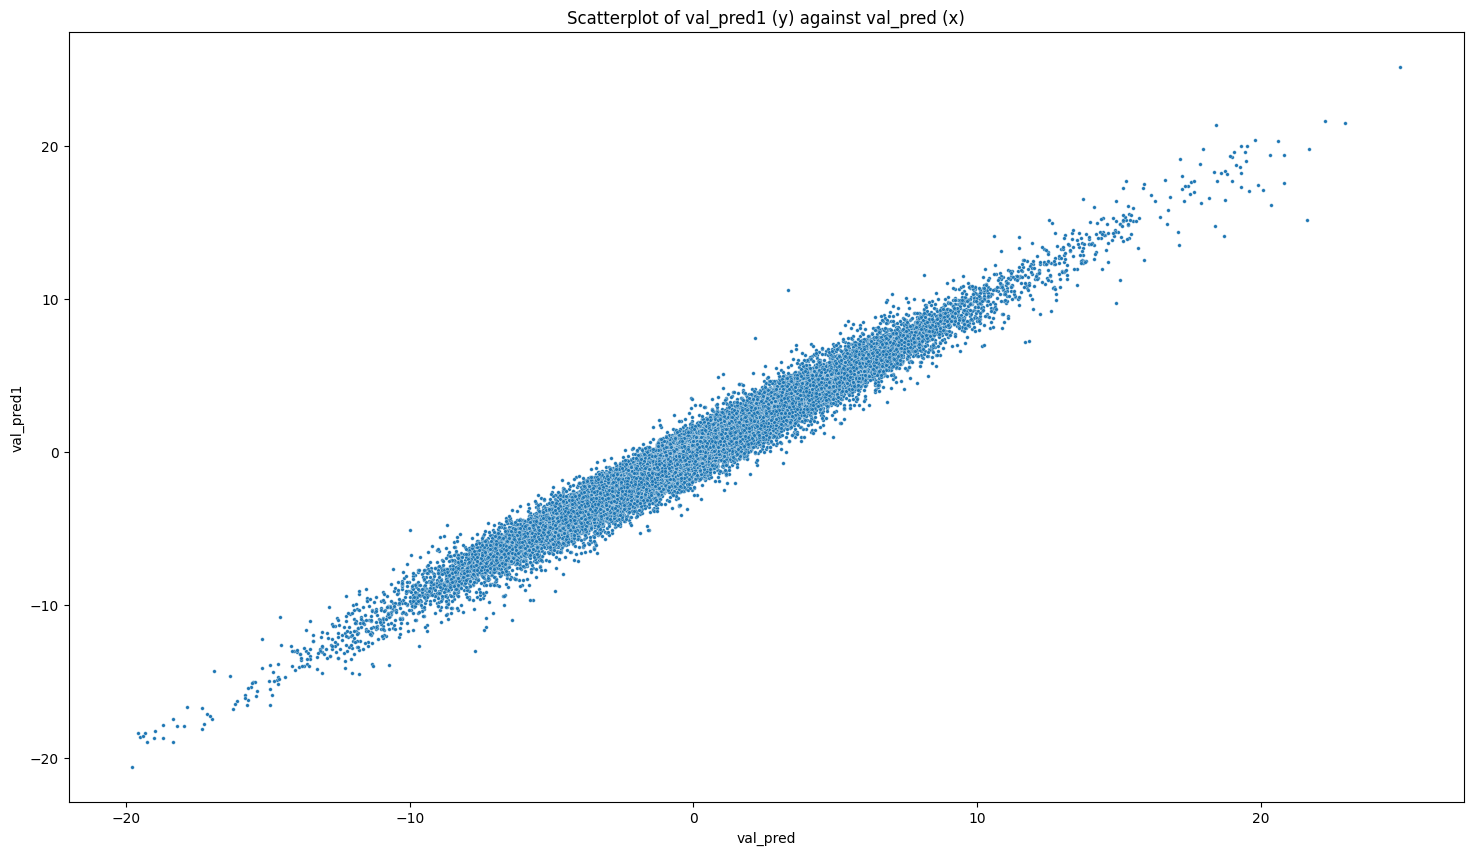

In [136]:
plot_scatterplot(lgbm, x_col="val_pred", y_col="val_pred1")

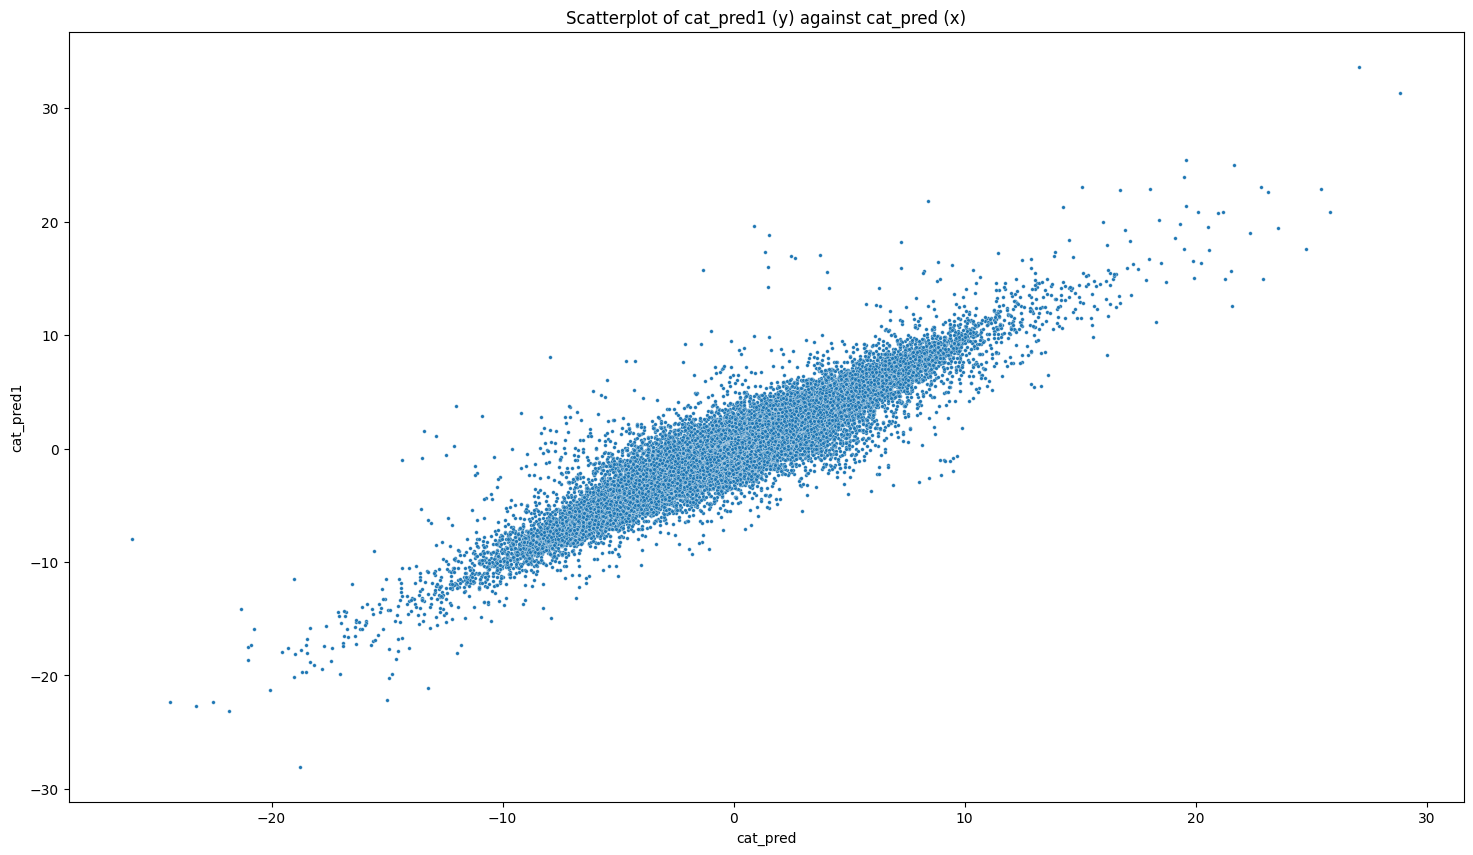

In [135]:
plot_scatterplot(lgbm, x_col="cat_pred", y_col="cat_pred1")